# Análisis Predictivo de Mantenimiento de Piscinas

## Introducción

Este notebook presentamos la segunda parte en el que se usaran tecnicas de Machine learning para crear un análisis predictivo para el mantenimiento de piscinas utilizando datos recopilados de sistemas de monitoreo automático. El objetivo es desarrollar un modelo que pueda predecir la necesidad de activación del clorificador y anticipar cambios en el pH del agua. Se usan los datos ya tratados en el previo notebook.

## Objetivos

1. Desarrollar un modelo de clasificación para predecir la necesidad de activación del clorificador.
2. Implementar un modelo de series temporales para predecir cambios futuros en el pH.
3. Integrar ambos modelos en un sistema de predicción en cascada.

## Estructura del Análisis

1. Carga y preprocesamiento de datos
2. Análisis exploratorio de datos (EDA)
<!-- 3. Desarrollo del modelo de clasificación para la activación del clorificador -->
4. Implementación del modelo de predicción de pH
5. Integración y evaluación del sistema completo
6. Conclusiones y recomendaciones

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tqdm import tqdm
import os

%matplotlib inline

En este análisis, hemos decidido comenzar entrenando nuestro modelo utilizando datos de un solo dispositivo (Device 01) en lugar de todos los dispositivos disponibles. Esta decisión se basa en varias consideraciones importantes:

1. **Variabilidad entre piscinas**: Cada piscina tiene condiciones únicas basadas en su localización, tamaño, uso y entorno. Esto se refleja en la variabilidad de los rangos de pH, ORP y otros parámetros entre los diferentes dispositivos, como se muestra en la tabla de resumen.

2. **Optimización específica**: Al entrenar un modelo para cada piscina individualmente, podemos optimizar el rendimiento para las condiciones específicas de esa piscina, lo que potencialmente conduce a predicciones más precisas y relevantes.

3. **Control de variables**: Comenzar con un solo dispositivo nos permite tener un mejor control sobre las variables y entender mejor cómo el modelo responde a un conjunto específico de condiciones antes de introducir la complejidad adicional de múltiples piscinas.

4. **Escalabilidad del enfoque**: Una vez que hayamos desarrollado y validado nuestro enfoque con un dispositivo, podremos escalar el proceso a los demás dispositivos, ya sea entrenando modelos individuales para cada uno o explorando técnicas de transferencia de aprendizaje.

5. **Comparación de rendimiento**: Este enfoque nos permitirá comparar el rendimiento del modelo entre diferentes piscinas, lo que puede proporcionar insights valiosos sobre qué factores influyen más en la precisión de las predicciones.

6. **Personalización del mantenimiento**: Al modelar cada piscina por separado, podemos ofrecer recomendaciones de mantenimiento más personalizadas y precisas para cada instalación.

Comenzaremos con el Device 01 como nuestro caso de estudio inicial. Este dispositivo muestra un rango de pH de 7.14 a 7.89, con un promedio de 7.52, lo cual es representativo de una piscina bien mantenida. Su rango de ORP de 381 a 803 mV también proporciona una buena variabilidad para nuestro análisis.

Una vez que hayamos desarrollado un modelo robusto para el Device 01, aplicaremos las lecciones aprendidas y las técnicas desarrolladas a los otros dispositivos, adaptando nuestro enfoque según sea necesario para cada caso único.

| Device    | pH min | pH max | pH avg | pH target | pH diff | ORP min | ORP max | ORP avg | ORP target | ORP diff | Cantidad de data |
|----------|--------|--------|--------|-----------|---------|---------|---------|---------|------------|----------|------------------|
| Device 01 | 7.14 | 7.89 | 7.52 | 7.4 | 0.12 | 381 | 803 | 625 | 645 | 20 | 4348 |
| Device 06 | 7.2 | 7.55 | 7.35 | 7.6 | 0.25 | 468 | 803 | 640 | 645 | 5 | 2953 |
| Device 07 | 7.2 | 7.51 | 7.38 | 7.5 | 0.12 | 567 | 662 | 614 | 650 | 36 | 1770 |
| Device 05 | 6.9 | 8.0 | 7.44 | 7.6 | 0.16 | 586 | 754 | 677 | 630 | 47 | 1735 |
| Device 03 | 7.15 | 7.53 | 7.35 | 7.4 | 0.05 | 454 | 687 | 563 | 590 | 27 | 3964 |
| Device 04 | 7.0 | 8.33 | 7.62 | 7.4 | 0.22 | 593 | 727 | 660 | 630 | 30 | 4294 |
| Device 10 | 7.3 | 9.3 | 7.65 | 7.4 | 0.25 | 596 | 716 | 648 | 650 | 2 | 1011 |
| Device 08 | 7.2 | 7.51 | 7.38 | 7.1 | 0.28 | 567 | 662 | 614 | 520 | 94 | 1770 |
| Device 09 | 8.9 | 10.0 | 9.81 | 7.4 | 2.41 | 178 | 436 | 283 | 650 | 367 | 602 |
| Device 02 | 8.9 | 10.0 | 9.81 | 7.5 | 2.31 | 178 | 436 | 283 | 680 | 397 | 602 |

In [2]:
# Cargamos los datos
try:
    base_path = r"..\DATA\Processed_Data"
    df_01 = pd.read_csv(os.path.join(base_path, 'datos_limpios_Device01.csv'))
    print(f"Datos cargados exitosamente")
    print(df_01.shape)
    print(df_01.head(2))
    
    df_01['Time'] = pd.to_datetime(df_01['Time'])
    df_01.set_index('Time', inplace=True)
    df_01.sort_index(inplace=True)
except Exception as e:
    print(f'Se ha producido un error: {e}')

Datos cargados exitosamente
(4348, 7)
      Device                 Time   PH  ORP  Salinity  Temperature  \
0  Device 01  2024-01-18 00:08:34  7.5  644      5181           25   
1  Device 01  2024-01-18 10:24:45  7.6  611      5207           24   

   Flow status  
0            1  
1            1  


## Enfoque Secuencial para el Control de la Piscina

Nuestro proyecto sigue un enfoque secuencial que refleja el proceso real de mantenimiento de una piscina:

1. **Predicción de la Activación del Clorificador**
   - Utilizamos el umbral de ORP < 650 para determinar cuándo activar el clorificador.
   - Este paso es crucial para mantener niveles adecuados de desinfección en la piscina.

2. **Análisis del Impacto de la Cloración**
   - Observamos que la activación del clorificador tiene efectos cascada:
     a) Aumenta el ORP (lo cual es el objetivo directo)
     b) Como consecuencia, también aumenta el pH del agua

3. **Predicción y Control del pH**
   - El aumento del pH debido a la cloración requiere una acción correctiva.
   - Aquí es donde entra en juego nuestro segundo modelo de machine learning.

### Justificación del Enfoque Actual

1. **Modelo de Clasificación para Cloración**
   - Aunque simple, este modelo representa fielmente el proceso de decisión actual para la activación del clorificador.
   - Sirve como base para el análisis subsiguiente y nos permite identificar claramente los momentos de cloración.

2. **Modelo de Predicción de pH (LSTM)**
   - Este modelo más complejo es crucial para anticipar los cambios en el pH tras la cloración.
   - Nos permite predecir cuándo y cuánto ácido será necesario inyectar para mantener el pH en niveles óptimos.

#### 1. Modelo de Clasificación para Activación del Clorificador

Preparamos los datos y entrenamos un modelo Random Forest para predecir cuándo se necesita activar el clorificador.

Informe de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       399
           1       1.00      1.00      1.00       471

    accuracy                           1.00       870
   macro avg       1.00      1.00      1.00       870
weighted avg       1.00      1.00      1.00       870


Matriz de confusión:
[[399   0]
 [  0 471]]


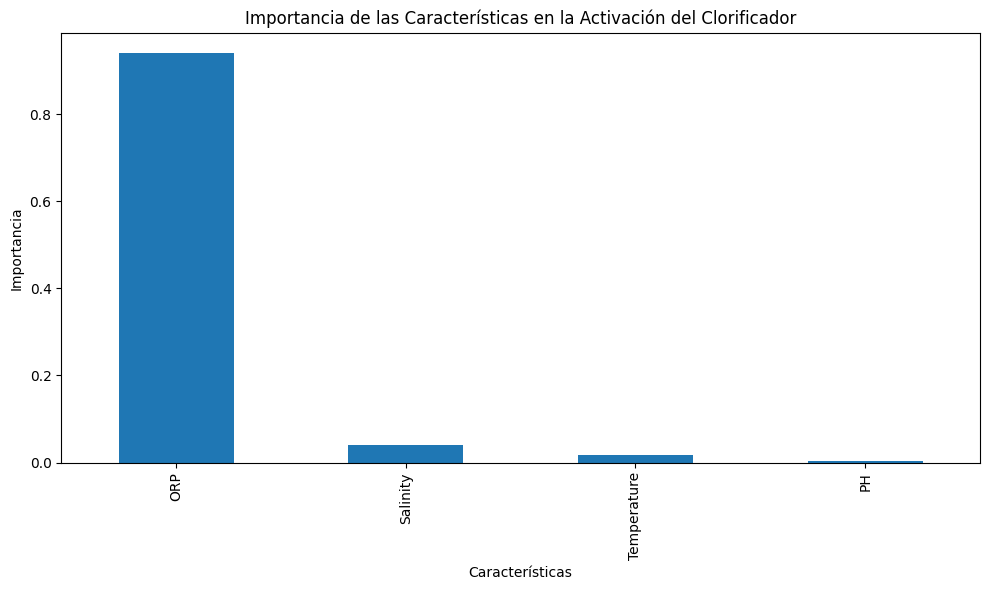

In [3]:
# Preparar los datos para la clasificación para el parametro ORP

df_01['Activa_Clorificador'] = (df_01['ORP'] < 645).astype(int)
X_clf = df_01[['PH', 'ORP', 'Salinity', 'Temperature']]
y_clf = df_01['Activa_Clorificador']

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)

# Entrenamos
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_clf, y_train_clf)

# Evaluamos
y_pred_clf = clf.predict(X_test_clf)
print("Informe de clasificación:")
print(classification_report(y_test_clf, y_pred_clf))
print("\nMatriz de confusión:")
print(confusion_matrix(y_test_clf, y_pred_clf))

# Guardamos las predicciones del clorificador 
df_01['Prediccion_Clorificador'] = clf.predict(X_clf)

imp_clf = clf.feature_importances_
feature_imp_clf = pd.Series(imp_clf, index=X_clf.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feature_imp_clf.plot(kind='bar')
plt.title('Importancia de las Características en la Activación del Clorificador')
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.tight_layout()
plt.show()

#### 2.Modelo de Predicción de pH

Preparamos los datos, escalamos y entrenamos un modelo. Desarrollaremos los dos modelos interconectados.

En sistemas dinámicos como una piscina, los valores actuales de pH dependen tanto de las condiciones presentes como de las pasadas. Para capturar esta relación temporal, se pueden utilizar valores anteriores (rezagados) del pH y el ORP. Esto nos permite ver cómo estos valores históricos influyen en el pH actual. Por ejemplo:

- El pH actual puede estar influenciado por sus valores anteriores debido a la inercia química del agua.
- Los cambios en ORP (potencial de oxidación-reducción) pueden tener un efecto retardado sobre el pH.
- Para capturar esta influencia, crearemos una nueva columna con los valores de pH desplazados una posición hacia abajo, representando el valor de pH en el tiempo anterior.

In [4]:
# Creamps variables de rezago
for i in range(1, 4):  
    df_01[f'PH_lag_{i}'] = df_01['PH'].shift(i)
    df_01[f'ORP_lag_{i}'] = df_01['ORP'].shift(i)

df_01.dropna(inplace=True)

# Preparamps features y target
X_reg = df_01[['ORP', 'Salinity', 'Temperature', 'PH_lag_1', 'PH_lag_2', 'PH_lag_3', 
               'ORP_lag_1', 'ORP_lag_2', 'ORP_lag_3', 'Prediccion_Clorificador']]
y_reg = df_01['PH']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Normalizamos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reg)
X_test_scaled = scaler.transform(X_test_reg)

print("Forma de los datos de entrenamiento:", X_train_scaled.shape)
print("Forma de los datos de prueba:", X_test_scaled.shape)
print("Características utilizadas:", X_reg.columns.tolist())


Forma de los datos de entrenamiento: (3476, 10)
Forma de los datos de prueba: (869, 10)
Características utilizadas: ['ORP', 'Salinity', 'Temperature', 'PH_lag_1', 'PH_lag_2', 'PH_lag_3', 'ORP_lag_1', 'ORP_lag_2', 'ORP_lag_3', 'Prediccion_Clorificador']


#### Comparación de Modelos

Compararemos varios modelos de regresión para predecir el pH para ver cual se ajusta mejor al funcionamiento de nuestr sistema.

1. Regresión Lineal: Modelo simple que asume una relación lineal entre las variables. Este aunque sencillo podria ajustarse a nuestras necesidades dado que sabemos que existe una relacion creciente entre los parametros.
2. Random Forest: Conjunto de árboles de decisión que podria ayudarnos a capturar relaciones no lineales existentes entre los parametros.
3. Gradient Boosting:Construye modelos de forma iterativa.
4. Red Neuronal: Puede aprender patrones complejos y no lineales en los datos que le aportamos.


Regresión Lineal - MSE: 0.0124, R2: 0.4177


C:\Users\hp\OneDrive\Escritorio\MASTER PYTHON 1\Master Python\11_Hacking\TFM\env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Random Forest - MSE: 0.0066, R2: 0.6891
Gradient Boosting - MSE: 0.0079, R2: 0.6283
Error en Red Neuronal: object __array__ method not producing an array


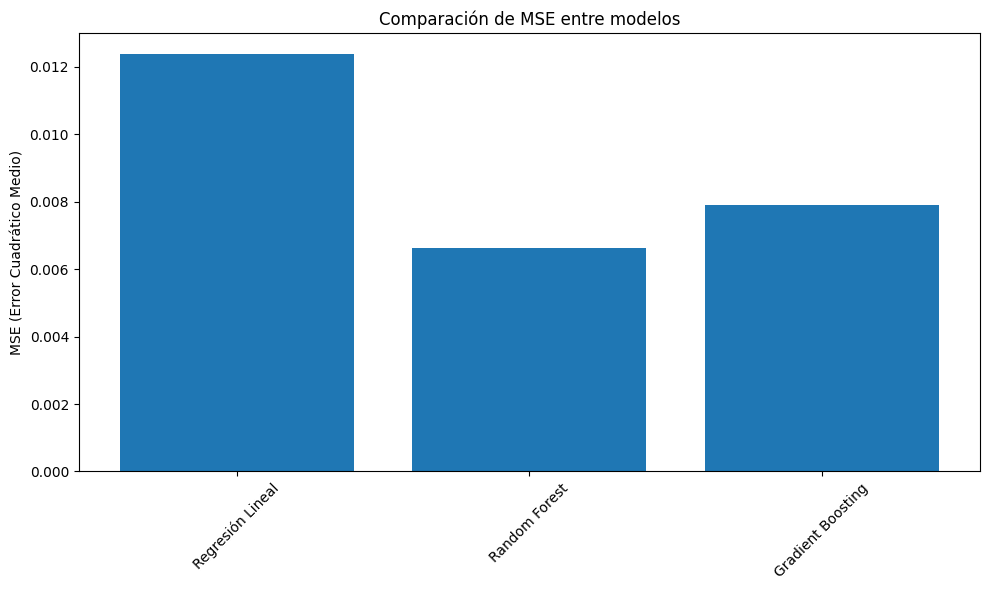

In [5]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

models = {
    'Regresión Lineal': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Red Neuronal': Sequential([
        Dense(64, activation='relu', input_shape=[X_train_scaled.shape[1]]),
        Dense(32, activation='relu'),
        Dense(1)
    ])
}

results = {}

for name, model in models.items():
    try:
        if name == 'Red Neuronal':
            model.compile(optimizer='adam', loss='mse')
            model.fit(X_train_scaled, y_train_reg, epochs=100, verbose=0)
            y_pred = model.predict(X_test_scaled)
            mse = mean_squared_error(y_test_reg, y_pred)
            r2 = r2_score(y_test_reg, y_pred)
        else:
            mse, r2 = evaluate_model(model, X_train_scaled, X_test_scaled, y_train_reg, y_test_reg)
        
        results[name] = {'MSE': mse, 'R2': r2}
        print(f"{name} - MSE: {mse:.4f}, R2: {r2:.4f}")
    except Exception as e:
        print(f"Error en {name}: {e}")

plt.figure(figsize=(10, 6))
plt.bar(results.keys(), [r['MSE'] for r in results.values()])
plt.title('Comparación de MSE entre modelos')
plt.ylabel('MSE (Error Cuadrático Medio)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

*Conclusiones* 
A partir de la comparación del Error Cuadrático Medio  podemos concluir que el Random Forest es el modelo con mejor rendimiento, seguido de cerca por Gradient Boosting, lo que sugiere que las relaciones entre las variables de entrada y el pH no son lineales lo cual se confirma dado que La Regresión Lineal tiene el MSE más alto. La Red Neuronal, aunque muestra un rendimiento intermedio, no supera a los métodos basados en árboles, quiza mejoraria con mas datos de entrada. 

Optimizaremos el Random Forest y se hara un ajuste de los hiperparametros para los dos mejores modelos.

In [6]:
# Creamos una clase progreso porque tardaba mucho en iterar y daba error así podemos controlar cómo va la compilación
class Progreso:
    def __init__(self, total):
        self.barra_progreso = tqdm(total=total, desc="Optimizando parámetros")

    def __call__(self, estudio, prueba):
        self.barra_progreso.update(1)

    def cerrar(self):
        self.barra_progreso.close()

# Dadas las previas conclusiones RandomForest como nuestro modelo principal
modelo_Forest = RandomForestRegressor(random_state=42)

# Ampliamos el espacio de parámetros para mejorar la optimización
parametros = {
    'n_estimators': [100, 200, 300],  
    'max_depth': [10, 20, 30],  
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4],  
    'max_features': ['sqrt', 'log2'], 
    'bootstrap': [True, False]
}

num_iteraciones = 20  # Asegúrate de que el número de combinaciones sea mayor o igual a 20.

# Llamo a la clase
rastreador = Progreso(num_iteraciones)

try:
    buscador_random = RandomizedSearchCV(
        modelo_Forest, 
        param_distributions=parametros, 
        n_iter=num_iteraciones,  
        cv=2,  # Reducimos a 2 folds para la validación cruzada
        random_state=42, 
        n_jobs=1,  # Limitamos a un trabajo paralelo para evitar problemas de recursos
        scoring='neg_mean_squared_error',
        error_score='raise',
        verbose=3  # Verbosidad para monitorear el proceso
    )

    # Progreso
    buscador_random.fit(X_train_scaled, y_train_reg)
    rastreador(None, None)

    print("\nMejores parámetros encontrados:\n")
    print(buscador_random.best_params_)

    modelo_optimo = buscador_random.best_estimator_
    y_pred = modelo_optimo.predict(X_test_scaled)
    MSE = mean_squared_error(y_test_reg, y_pred)
    r2 = r2_score(y_test_reg, y_pred)
    print(f"Modelo RandomForest optimizado - MSE: {MSE:.4f}, R2: {r2:.4f}")

except Exception as e:
    print(f"\nSe produjo un error durante la optimización: {str(e)}")

finally:
    rastreador.cerrar()


Optimizando parámetros:   0%|                    | 0/20 [00:00<?, ?it/s]

Fitting 2 folds for each of 20 candidates, totalling 40 fits
[CV 1/2] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=-0.007 total time=   0.1s
[CV 2/2] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=-0.009 total time=   0.1s
[CV 1/2] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=-0.007 total time=   0.2s
[CV 2/2] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=-0.008 total time=   0.2s
[CV 1/2] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=-0.007 total time=   0.7s
[CV 2/2] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=-0.008 total time=   0.7s
[CV 1/2] END 

C:\Users\hp\OneDrive\Escritorio\MASTER PYTHON 1\Master Python\11_Hacking\TFM\env\lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
Optimizando parámetros:   5%|▌           | 1/20 [00:21<06:57, 21.99s/it]


Mejores parámetros encontrados:

{'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30, 'bootstrap': False}
Modelo RandomForest optimizado - MSE: 0.0064, R2: 0.7004


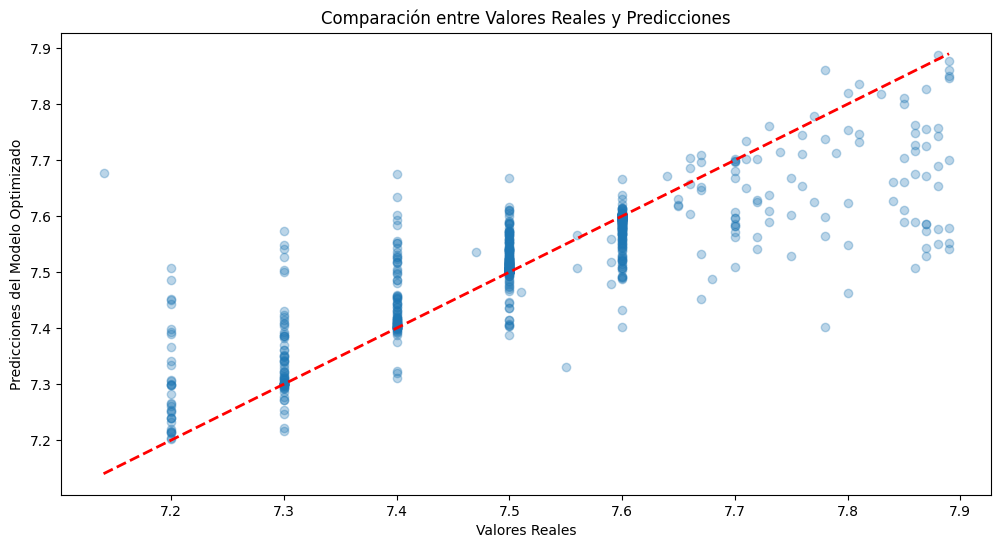

In [7]:
# Predicciones del modelo optimizado
y_pred_optimo = modelo_optimo.predict(X_test_scaled)

# Visualización
plt.figure(figsize=(12, 6))
plt.scatter(y_test_reg, y_pred_optimo, alpha=0.3)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones del Modelo Optimizado')
plt.title('Comparación entre Valores Reales y Predicciones')
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
plt.show()